## Imports and Setup

In [ ]:
import os
import sys
sys.path.insert(0, "../utils/")
import cnn_utils
import config_utils

import pandas as pd
import numpy as np
import geopandas as gpd

import torchsummary
import torch

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Configuration

In [4]:
iso_code = "SEN"
config_file = "configs/cnn_configs/convnext_large_v01.yaml"

cwd = os.path.dirname(os.getcwd())
config = config_utils.load_config(os.path.join(cwd, config_file))
config["iso_codes"] = [iso_code]
data, data_loader, classes = cnn_utils.load_dataset(config, phases=["train", "val", "test"])

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/GIGAv4/train/SEN_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  SEN  non_school   7141    0.372043
1  rural  SEN      school   4443    0.231479
2  urban  SEN  non_school   5655    0.294623
3  urban  SEN      school   1955    0.101855
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  SEN non_school test       712    0.371027
                      train     5765         NaN
                      val        664    0.346014
           school     test       446    0.232413
                      train     3585         NaN
                      val        412    0.214695
urban  SEN non_school test       565    0.294424
                      train     4529         NaN
                      val        561    0.292340
           school     test       195    0.101615
                      train     1582         NaN
                      

## Visualize Samples

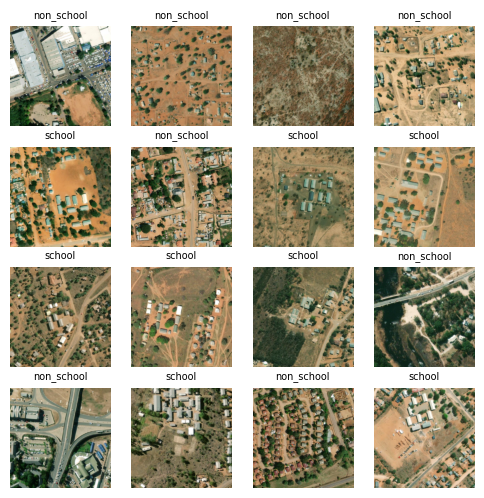

In [25]:
cnn_utils.visualize_data(data, data_loader, phase='train', normalize=config["normalize"])

## Load Model

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=2,
    model_type=config["model"],
    pretrained=config["pretrained"],
    scheduler_type=config["scheduler"],
    optimizer_type=config["optimizer"],
    label_smoothing=config["label_smoothing"],
    lr=config["lr"],
    momentum=config["momentum"],
    gamma=config["gamma"],
    step_size=config["step_size"],
    patience=config["patience"],
    dropout=config["dropout"],
    device=device,
)
torchsummary.summary(model, (3, 500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 125, 125]           6,272
       LayerNorm2d-2        [-1, 128, 125, 125]             256
            Conv2d-3        [-1, 128, 125, 125]           6,400
           Permute-4        [-1, 125, 125, 128]               0
         LayerNorm-5        [-1, 125, 125, 128]             256
            Linear-6        [-1, 125, 125, 512]          66,048
              GELU-7        [-1, 125, 125, 512]               0
            Linear-8        [-1, 125, 125, 128]          65,664
           Permute-9        [-1, 128, 125, 125]               0
  StochasticDepth-10        [-1, 128, 125, 125]               0
          CNBlock-11        [-1, 128, 125, 125]               0
           Conv2d-12        [-1, 128, 125, 125]           6,400
          Permute-13        [-1, 125, 125, 128]               0
        LayerNorm-14        [-1, 125, 1

## LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.63E-04


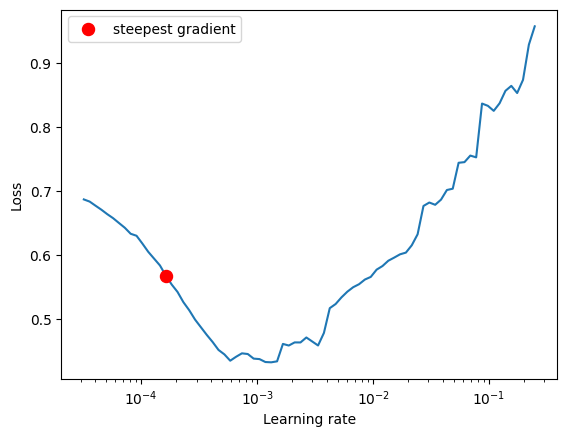

INFO:root:Best lr: 0.00016297508346206443


In [10]:
lr = cnn_utils.lr_finder(
    data_loader, 
    model, 
    optimizer, 
    criterion, 
    device, 
    end_lr=1.0, 
    num_iter=100, 
    plot=True
)